In [1]:
import sys
import matplotlib as m

sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../..')

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from absl import app
from absl import flags

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
import tensorflow_lattice as tfl

from dcc import AAV, Parameters
import numpy as np
import matplotlib.pyplot as plt

import patsy
from scipy.interpolate import BSpline

Lets start by a 1-D spline regression

In [2]:
x = np.linspace(0, 100, 1000)
# y_true = np.divide(np.sqrt(x) + 10, (x+10)) + x/100
y_true = np.divide(1, 1 + np.exp(-x + 50)) + x/100

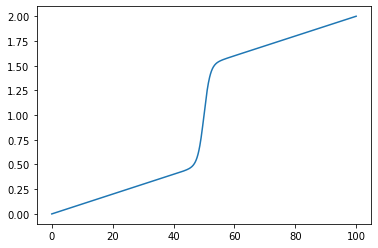

In [3]:
plt.plot(x, y_true)

Text(0.5, 1.0, 'In SciPy')

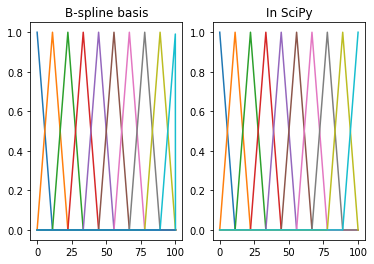

In [4]:
import patsy # for comparison

these_knots = np.linspace(0,100,10)

# PATSY R implementation
p = 1
# in Patsy/R: nice and sensible
y = patsy.bs(x, knots=these_knots, degree=p)
plt.subplot(1,2,1)
plt.plot(x,y)
plt.title('B-spline basis')

# Scipy implemntation
numpyknots = np.concatenate(([0] * p ,these_knots, [100] * p)) # because??
y_py = np.zeros((x.shape[0], len(these_knots)+ p - 1))
for i in range(len(these_knots) + p - 1):
    y_py[:,i] = BSpline(numpyknots, (np.arange(len(these_knots)+ p - 1)==i).astype(float), p, extrapolate=False)(x)

plt.subplot(1,2,2)
plt.plot(x,y_py)
plt.title('In SciPy')

Sum of all the basis elements is 1

In [5]:
np.array([BSpline(numpyknots, (np.arange(len(these_knots)+p-1)==i).astype(float), p, extrapolate=False)(4) for i in range(len(these_knots)+p-1)]).sum()

0.9999999999999999

Let's see how we can retreive derivatives

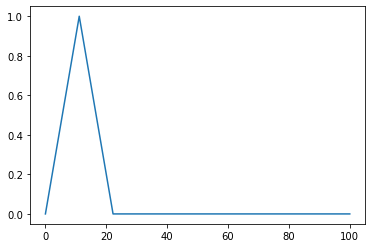

In [6]:
plt.plot(x, BSpline(numpyknots, (np.arange(len(these_knots)+p-1)==1).astype(float), p, extrapolate=False)(x))
if p>1:
    plt.plot(x, BSpline(numpyknots, (np.arange(len(these_knots)+p-1)==1).astype(float), p, extrapolate=False).derivative()(x))
if p>2:
    plt.plot(x, BSpline(numpyknots, (np.arange(len(these_knots)+p-1)==1).astype(float), p, extrapolate=False).derivative().derivative()(x))

In [7]:
# BSpline(numpyknots, (np.arange(len(these_knots)+p-1)==1).astype(float), p, extrapolate=False)

Now lets build a model tf2 model -- starting with the transform procedure

In [38]:
these_knots = np.linspace(0, 100, 10)
def transform_1d(eval_point, p=3):
    numpyknots = np.concatenate(([0]*p,these_knots,[100]*p)) 
    y_py = np.zeros((eval_point.shape[0], len(these_knots) + p - 1 + 1))
    y_py[:, 0] = eval_point
    for i in range(len(these_knots)+p-1):
        y_py[:,i+1] = BSpline(numpyknots, (np.arange(len(these_knots)+p-1)==i).astype(float), p, extrapolate=False)(eval_point)
    return y_py

def transform_1d_der(eval_point, p=3):
    numpyknots = np.concatenate(([0]*p,these_knots,[100]*p)) 
    y_py = np.zeros((eval_point.shape[0], len(these_knots)+p-1) )
    #y_py[:, 0] = eval_point
    for i in range(len(these_knots)+p-1):
        y_py[:,i] = BSpline(numpyknots, (np.arange(len(these_knots)+p-1)==i).astype(float), p, extrapolate=False).derivative()(eval_point)
        
    return y_py

In [15]:
p = 3
features = len(these_knots) + p - 1 + 1
inputs = tf.keras.Input(shape=(features,))
first_layer = tf.keras.layers.Dense(1, activation='linear', use_bias=False)(inputs[:, 1:])
model = tf.keras.Model(inputs=inputs, outputs=first_layer, name="combined")
model.compile(loss=tf.keras.losses.mean_squared_error, optimizer='adam')

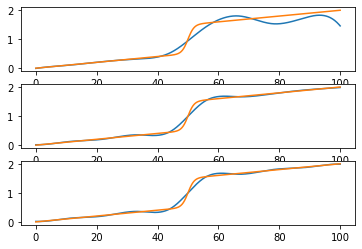

In [16]:
bs = 30
epochs = 100 
model.fit(transform_1d(x, p), y_true, epochs=epochs, verbose=False, batch_size=bs, shuffle=True)
fig, ax = plt.subplots(nrows = 3)
y_pred = model.predict_on_batch(transform_1d(x, p)).flatten()
ax[0].plot(x, y_pred)
ax[0].plot(x, y_true)
model.fit(transform_1d(x, p), y_true, epochs=epochs, verbose=False, batch_size=bs, shuffle=True)
y_pred = model.predict_on_batch(transform_1d(x, p)).flatten()
ax[1].plot(x, y_pred)
ax[1].plot(x, y_true)
model.fit(transform_1d(x, p), y_true, epochs=epochs, verbose=False, batch_size=bs, shuffle=True)
y_pred = model.predict_on_batch(transform_1d(x, p)).flatten()
ax[2].plot(x, y_pred)
ax[2].plot(x, y_true)

Fit multiple times until the fit is persuasive

34/34 [==============================] - 0s 397us/step - loss: 0.0025


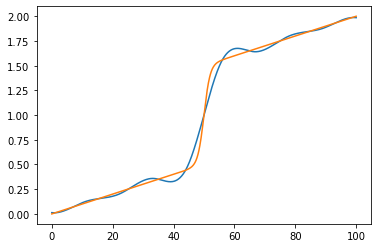

In [17]:
model.fit(transform_1d(x, p), y_true, epochs=1, batch_size=bs)
y_pred = model.predict_on_batch(transform_1d(x)).flatten()
plt.plot(x, y_pred)
plt.plot(x, y_true)

### Custom fitting method inheriting from keras.Model
Lets try to build our own custom fitting procedure that can be accommodated for including penalization does not take into account the order of the spline basis

In [18]:
# loss_tracker = keras.metrics.Mean(name="loss")
# mae_metric = keras.metrics.MeanAbsoluteError(name="mae")

# class CustomModel(keras.Model):
#     def __init__(self, *args, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.i = 0
        
#     def train_step(self, data):
#         # Unpack the data. Its structure depends on your model and
#         # on what you pass to `fit()`.
#         x, y = data
#         self.i += 1
#         with tf.GradientTape() as tape:
#             y_pred = self(x, training=True)  # Forward pass
#             # Compute the loss value
#             # (the loss function is configured in `compile()`)
#             loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)#  tf.reduce_sum(tf.maximum(-tf.matmul(tf.numpy_function(transform_1d, [x], tf.float32, name=None), model.weights[0]), 0))


#         # Compute gradients
#         trainable_vars = self.trainable_variables
#         gradients = tape.gradient(loss, trainable_vars)
#         # Update weights
#         self.optimizer.apply_gradients(zip(gradients, trainable_vars))
#         # Update metrics (includes the metric that tracks the loss)
#         self.compiled_metrics.update_state(y, y_pred)
#         # Return a dict mapping metric names to current value
#         return {m.name: m.result() for m in self.metrics}
    
# features = len(these_knots) + 2

# inputs_c = tf.keras.Input(shape=(features,))
# first_layer_c = tf.keras.layers.Dense(1, activation='linear', use_bias=False)(inputs_c)
# modelc = CustomModel(inputs=inputs, outputs=first_layer, name="custom")
# modelc.compile(loss=tf.keras.losses.mean_squared_error, optimizer='adam')

In [19]:
# bs = 32
# epochs = 100
# modelc.fit(transform_1d(x), y_true, epochs=epochs, verbose=False, batch_size=bs)
# fig, ax = plt.subplots(nrows = 3)
# y_pred = modelc.predict_on_batch(transform_1d(x)).flatten()
# ax[0].plot(x, y_pred)
# ax[0].plot(x, y_true)
# modelc.fit(transform_1d(x), y_true, epochs=epochs, verbose=False, batch_size=bs)
# y_pred = modelc.predict_on_batch(transform_1d(x)).flatten()
# ax[1].plot(x, y_pred)
# ax[1].plot(x, y_true)
# modelc.fit(transform_1d(x), y_true, epochs=epochs, verbose=False, batch_size=bs)
# y_pred = modelc.predict_on_batch(transform_1d(x)).flatten()
# ax[2].plot(x, y_pred)
# ax[2].plot(x, y_true)

In [20]:
# modelc.fit(transform_1d(x), y_true, epochs=1)
# y_pred = modelc.predict_on_batch(transform_1d(x)).flatten()
# plt.plot(x, y_pred)
# plt.plot(x, y_true)

### Fitting with gradient tape
Lets try fitting 1-D function together with monotonicity penalization -- I suspect this is eager execution compared to .fit() which is not eager. This is the result of the discrepancytransform_1d

In [39]:
transform_1d_der([(i, j) for i,j in tf.data.Dataset.from_tensor_slices((transform_1d(x), y_true)).batch(32)][0][0][:, 0].numpy()).shape

(32, 12)

In [84]:
features = len(these_knots) + p -1 + 1

inputs_cp = tf.keras.Input(shape=(features,))
first_layer_cp = tf.keras.layers.Dense(1, activation='linear', use_bias=False)(inputs_cp[:, 1:])
modelcp = tf.keras.Model(inputs=inputs_cp, outputs=first_layer_cp, name="custom")
modelcp.compile(loss=tf.keras.losses.mean_squared_error, optimizer='adam')


inputs_cpenal = tf.keras.Input(shape=(features,))
first_layer_cpenal = tf.keras.layers.Dense(1, activation='linear', use_bias=False)(inputs_cpenal[:, 1:])
modelcpenal = tf.keras.Model(inputs=inputs_cpenal, outputs=first_layer_cpenal, name="customp")
modelcpenal.compile(loss=tf.keras.losses.mean_squared_error, optimizer='adam')

# modelcpenal = tf.keras.models.clone_model(modelcp)
starting_weights = modelcp.get_weights().copy()
modelcpenal.set_weights(starting_weights)

def reset_weights(model):
    model.set_weights(starting_weights)
        

def train_step(X, y, batch=32):
    epoch_losses = []
    for x_batch, y_batch in tf.data.Dataset.from_tensor_slices((X, y)).batch(batch):
        with tf.GradientTape() as tape:
            predictions = modelcp(x_batch, training=True)
            loss_value = tf.reduce_sum(tf.keras.losses.mean_squared_error(y_batch, predictions))
            epoch_losses.append(loss_value.numpy())
        gradients = tape.gradient(loss_value, modelcp.trainable_variables)
        modelcp.optimizer.apply_gradients(zip(gradients, modelcp.trainable_variables))
    return np.mean(epoch_losses)


def fit_model(x, y, epochs, batch=32, verbose=False):
    losses = np.zeros(epochs)
    for i, epoch in enumerate(range(0, epochs)):
        losses[i] = train_step(x, y, batch)
        if verbose:
            print(f'Loss: {loss}')
    return losses
            
            
def train_step_penal(X, y, penal_coeff, batch=32):
    epoch_losses = []
    penalizations = []
    for x_batch, y_batch in tf.data.Dataset.from_tensor_slices((X, y)).batch(batch):
        with tf.GradientTape() as tape:
            predictions = modelcpenal(x_batch, training=False)
            penalization = penal_coeff * np.sum(np.maximum(-np.matmul(transform_1d_der(x_batch[:, 0].numpy()), modelcpenal.weights[0].numpy()), 0))
            loss_value = tf.reduce_sum(tf.keras.losses.mean_squared_error(y_batch, predictions)) + penalization
            epoch_losses.append(loss_value.numpy())
            penalizations.append(penalization)
        gradients = tape.gradient(loss_value, modelcpenal.trainable_variables)
        modelcpenal.optimizer.apply_gradients(zip(gradients, modelcpenal.trainable_variables))
    return (np.mean(epoch_losses), np.mean(penalizations))


def fit_model_penal(x, y, epochs, penal_coeff, verbose=False, batch=32):
    losses = np.zeros(epochs)
    penalizations = np.zeros(epochs)
    for i, epoch in enumerate(range(0, epochs)):
        losses[i], penalizations[i] = train_step_penal(x, y, penal_coeff=penal_coeff, batch=batch)
        if verbose:
            print(f'Loss: {loss}')   
    return losses, penalizations

In [85]:
bs = 100
n_epochs = 150
fit_model(transform_1d(x), y_true, epochs=n_epochs, verbose=False, batch=bs)
y_pred_0 = modelcp.predict_on_batch(transform_1d(x)).flatten()
fit_model(transform_1d(x), y_true, epochs=n_epochs, verbose=False, batch=bs)
y_pred_1 = modelcp.predict_on_batch(transform_1d(x)).flatten()
l = fit_model(transform_1d(x), y_true, epochs=n_epochs, verbose=False, batch=bs)
y_pred_2 = modelcp.predict_on_batch(transform_1d(x)).flatten()

[WARNING] [2020-12-03 15:24:59,872] [tensorflow] - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000002BB8CD54E58> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


In [86]:
penal_coeff = 500
spenal_1 = fit_model_penal(transform_1d(x), y_true, epochs=n_epochs, penal_coeff=penal_coeff, verbose=False, batch=bs)
y_pred_cp_0 = modelcpenal.predict_on_batch(transform_1d(x)).flatten()
spenal_2 = fit_model_penal(transform_1d(x), y_true, epochs=n_epochs, penal_coeff=penal_coeff, verbose=False, batch=bs)
y_pred_cp_1 = modelcpenal.predict_on_batch(transform_1d(x)).flatten()
spenal_2 = fit_model_penal(transform_1d(x), y_true, epochs=n_epochs, penal_coeff=penal_coeff, verbose=False, batch=bs)
y_pred_cp_2 = modelcpenal.predict_on_batch(transform_1d(x)).flatten()

[WARNING] [2020-12-03 15:25:13,386] [tensorflow] - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000002BB8CD61D38> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


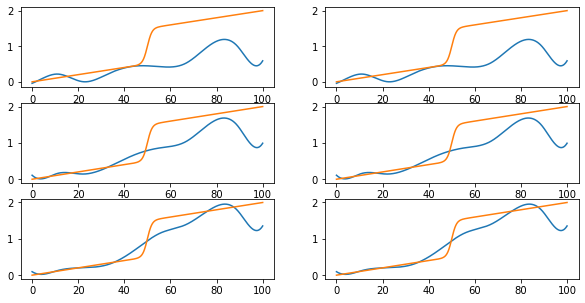

In [87]:
fig, ax = plt.subplots(nrows = 3, ncols=2, figsize=(10,5))
ax[0, 0].plot(x, y_pred_0)
ax[1, 0].plot(x, y_pred_1)
ax[2, 0].plot(x, y_pred_2)
ax[0, 0].plot(x, y_true)
ax[1, 0].plot(x, y_true)
ax[2, 0].plot(x, y_true)

ax[0, 1].plot(x, y_pred_cp_0)
ax[0, 1].plot(x, y_true)
ax[1, 1].plot(x, y_pred_cp_1)
ax[1, 1].plot(x, y_true)
ax[2, 1].plot(x, y_pred_cp_2)
ax[2, 1].plot(x, y_true) 

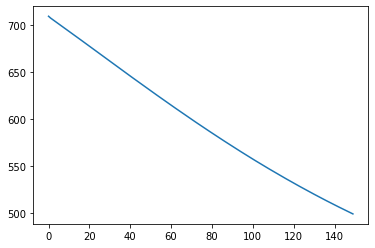

In [88]:
plt.plot(spenal_1[1])

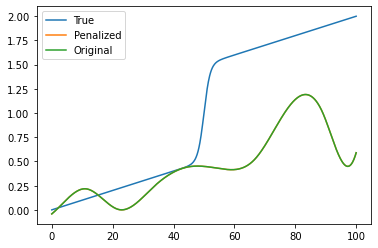

In [90]:
plt.plot(x, y_true)
plt.plot(x, y_pred_cp_0)
plt.plot(x, y_pred_0)
plt.legend(['True', 'Penalized', 'Original'])

## TODO design an experiment that tracks the error for different penalization

So this works, lets do tensor product of basis functions -- i.e. 2D approx of the "greedy" value function

In [58]:
starting_weights

[array([[-0.02551895],
        [-0.16015017],
        [-0.66756177],
        [ 0.324571  ],
        [-0.24807283],
        [-0.01367217],
        [ 0.4920677 ],
        [ 0.34664845],
        [ 0.17178845],
        [-0.30235776],
        [-0.40720275],
        [-0.38019463]], dtype=float32)]

In [59]:
modelcpenal.weights

[<tf.Variable 'dense_13/kernel:0' shape=(12, 1) dtype=float32, numpy=
 array([[ 2.0557897e-02],
        [-1.0603220e-03],
        [ 1.6958551e-01],
        [ 1.4919908e-01],
        [ 4.6123829e-01],
        [ 1.4231277e-01],
        [ 1.8577633e+00],
        [ 1.5392351e+00],
        [ 1.8502202e+00],
        [ 1.8314569e+00],
        [ 1.9995750e+00],
        [ 1.9809445e+00]], dtype=float32)>]

In [60]:
reset_weights(modelcpenal)

In [61]:
coeffs = [0, 1, 5, 10]
preds = []
losses = []
penals = []
for coefficient in coeffs:
    reset_weights(modelcpenal)
    loss, penal = fit_model_penal(transform_1d(x), y_true, epochs=500, penal_coeff=coefficient, verbose=False, batch=100)
    y_pred_cpenal = modelcpenal.predict_on_batch(transform_1d(x)).flatten()
    penals.append(penal)
    losses.append(loss)
    preds.append(y_pred_cpenal)

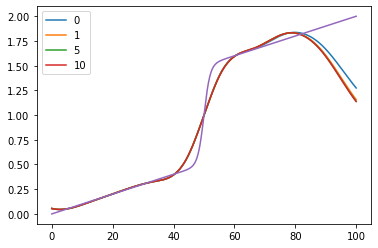

In [62]:
[plt.plot(x, preds[i]) for i, _ in enumerate(coeffs)]
plt.plot(x, y_true)
plt.legend(coeffs)

In [66]:
np.square(y_pred_cpenal - y_true).sum()

43.863399062380275

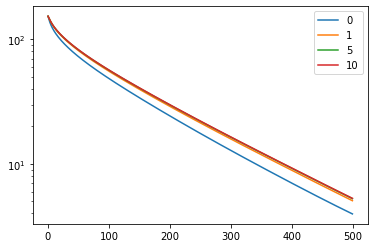

In [67]:

[plt.plot(losses[i] - penals[i]) for i, _ in enumerate(coeffs)]
plt.legend(coeffs)
plt.yscale('log')
# plt.xscale('log')


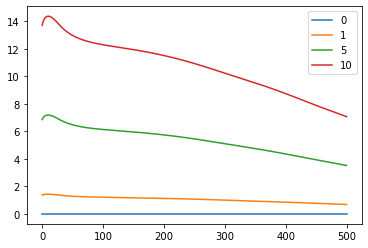

In [68]:
[plt.plot(penals[i]) for i, _ in enumerate(coeffs)]
plt.legend(coeffs)

### 2-D fitting to the q function

In [ ]:
p = Parameters()
aav= AAV(p)
ws = np.linspace(0, 200, 200)
ls = np.linspace(0, 5, 100)
ww, ll = np.meshgrid(ws, ls)
z = np.zeros_like(ww)
zt = np.zeros_like(ww)
coord = []
targets = []
for i, wx in enumerate(ws):
    for j, ly in enumerate(ls):
        z[j, i] = -aav.u(ly, wx)
        zt[j, i] = -aav.u(ly + 3, wx) - 15
        #features.append([ly, wx, z[j, i], zt[j, i]])
        coord.append([ly, wx])
        targets.append([z[j, i], zt[j, i]])
coord = np.array(coord)
targets = np.array(targets)

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=1)
CS = ax[0].contour(ww, ll, z)
ax[0].clabel(CS, inline=1, fontsize=10)
ax[0].set_title('q(1)')
CS = ax[1].contour(ww, ll, zt)
ax[1].clabel(CS, inline=1, fontsize=10)
ax[1].set_title('q(2)')

In [ ]:
these_knots_w = np.linspace(0,200, 6)
these_knots_l = np.linspace(0, 5, 3)
total_features = (len(these_knots_w)+2) * (len(these_knots_l)+2)
from itertools import product
def transform_1d_w(eval_point):
    numpyknots = np.concatenate(([0,0,0],these_knots_w,[200, 200, 200]))
    y_py = np.zeros((eval_point.shape[0], len(these_knots_w)+ 2 + 1))
    y_py[:, 0] = eval_point
    for i in range(len(these_knots_w) + 2):
        y_py[:,i+1] = BSpline.construct_fast(numpyknots, (np.arange(len(these_knots_w)+2)==i).astype(float), 3, extrapolate=False)(eval_point)
    return y_py
def transform_1d_l(eval_point):
    numpyknots = np.concatenate(([0,0,0],these_knots_l,[5, 5, 5]))
    y_py = np.zeros((eval_point.shape[0], len(these_knots_l) + 2 + 1))
    y_py[:, 0] = eval_point
    for i in range(len(these_knots_l)+2):
        y_py[:,i+1] = BSpline.construct_fast(numpyknots, (np.arange(len(these_knots_l)+2)==i).astype(float), 3, extrapolate=False)(eval_point)
    return y_py

def transform_2d(xy_inp):
    w_features = transform_1d_w(xy_inp[:, 1])
    l_features = transform_1d_l(xy_inp[:, 0])
    final = np.zeros((len(xy_inp), total_features + 2))
    final[:, 0] = l_features[:, 0]
    final[:, 1] = w_features[:, 1]
    for i, row in enumerate(w_features):
        final[i, 2:] = [i * j for i, j in product(row[1:], l_features[i, 1:])]
    return final

In [ ]:
features = transform_2d(coord)

In [ ]:
inputs = tf.keras.Input(shape=(total_features+2,))
first_layer = tf.keras.layers.Dense(2, activation='linear', use_bias=False)(inputs[:, 2:])
model = tf.keras.Model(inputs=inputs, outputs=first_layer, name="combined")
model.compile(loss=tf.keras.losses.mean_squared_error, optimizer='adam')

In [ ]:
model.fit(features, targets, epochs = 500, verbose=False)
model.fit(features, targets, epochs = 1)

In [ ]:
spline_pred = np.zeros_like(ww)
spline_pred2 = np.zeros_like(ww)
for i, wx in enumerate(ws):
    for j, ly in enumerate(ls):
        obs = np.array([ly, wx])
        pred = model.predict_on_batch(transform_2d(obs[None, :]))
        spline_pred[j, i] = pred[0][0]
        spline_pred2[j, i] = pred[0][1]
fig, ax = plt.subplots(ncols=2, nrows=1)

CS = ax[0].contour(ww, ll, spline_pred)
ax[0].clabel(CS, inline=1, fontsize=10)
ax[0].set_title('spline q(1)')
CS = ax[1].contour(ww, ll, spline_pred2)
ax[1].clabel(CS, inline=1, fontsize=10)
ax[1].set_title('spline q(2)')

omg: this shit works :D 

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=1)
CS = ax[0].contour(ww, ll, spline_pred- z)
ax[0].clabel(CS, inline=1, fontsize=10)
ax[0].set_title('vf')
CS = ax[1].contour(ww, ll, spline_pred2- zt)
ax[1].clabel(CS, inline=1, fontsize=10)
ax[1].set_title('vf')

Lets try the same but with convexity constraints. We define a loss function that penalizes for concavity in w ( i.e. we want convexity in w) and convexity in $w$, i.e., we want concavity in $\lambda$

In [ ]:
from tensorflow.keras.losses import Loss


def transform_1d_w_der(eval_point):
    numpyknots = np.concatenate(([0,0,0],these_knots_w,[200, 200, 200]))
    y_first = np.zeros((eval_point.shape[0], len(these_knots_w)+ 2))
    y_second = np.zeros_like(y_first)
    for i in range(len(these_knots_w) + 2):
        y_first[:,i] = BSpline.construct_fast(numpyknots, (np.arange(len(these_knots_w)+2)==i).astype(float), 3, extrapolate=False).derivative()(eval_point)
        y_second[:,i] = BSpline.construct_fast(numpyknots, (np.arange(len(these_knots_w)+2)==i).astype(float), 3, extrapolate=False).derivative().derivative()(eval_point)
    return y_first, y_second
        
    
    return y_first, y_second
def transform_1d_l_der(eval_point):
    numpyknots = np.concatenate(([0,0,0],these_knots_l,[5, 5, 5]))
    y_first = np.zeros((eval_point.shape[0], len(these_knots_l) + 2 ))
    y_second = np.zeros_like(y_first)
    for i in range(len(these_knots_l)+2):
        y_first[:,i] = BSpline.construct_fast(numpyknots, (np.arange(len(these_knots_l)+2)==i).astype(float), 3, extrapolate=False).derivative()(eval_point)
        y_second[:,i] = BSpline.construct_fast(numpyknots, (np.arange(len(these_knots_l)+2)==i).astype(float), 3, extrapolate=False).derivative().derivative()(eval_point)
    return y_first, y_second

def D(xy_inp):
    w_features = transform_1d_w(xy_inp[:, 1])
    l_features = transform_1d_l(xy_inp[:, 0])
    w_features_der, w_features_der2 = transform_1d_w_der(xy_inp[:, 1])
    l_features_der, l_features_der2 = transform_1d_l_der(xy_inp[:, 0])
    first_der_features = 40
    first_w = np.zeros((len(xy_inp), first_der_features))
    first_l = np.zeros_like(first_w)
#     final[:, 0] = l_features[:, 0]
#     final[:, 1] = w_features[:, 1]
    for i, row in enumerate(w_features):
        first_w[i, :] = [i * j for i, j in product(w_features_der[i, :], l_features[i, 1:])]
        first_l[i, :] = [i * j for i, j in product(w_features[i, 1:], l_features_der[i, :])]
    return first_w, first_l, 0, 0

def calculate_penalization(xy, model):
    first_l, first_w, second_w, second_l = penalization_2d(xy)
    # penal = np.sum(np.maximum(-np.matmul(first_l, model.weights[0].numpy()), 0 ), axis=0) + np.sum(np.maximum(-np.matmul(first_w, model.weights[0].numpy()), 0), axis=0)
    penal = np.maximum(-np.matmul(first_l, model.weights[0].numpy()), 0 ) + np.maximum(-np.matmul(first_w, model.weights[0].numpy()), 0)
    return penal

inputs_penal_2d = tf.keras.Input(shape=(total_features+2,))
first_layer_penal_2d = tf.keras.layers.Dense(2, activation='linear', use_bias=False)(inputs_penal_2d[:, 2:])
modelp2d = tf.keras.Model(inputs=inputs_penal_2d, outputs=first_layer_penal_2d, name="combined")
modelp2d.compile(loss=tf.keras.losses.mean_squared_error, optimizer='adam')

def train_step_penal_2d(X, y, batch=32):
    epoch_losses = []
    for x_batch, y_batch in tf.data.Dataset.from_tensor_slices((X, y)).batch(batch):
        with tf.GradientTape() as tape:
            predictions = modelp2d(x_batch, training=True)
            loss_value = tf.reduce_sum(tf.keras.losses.mean_squared_error(y_batch, predictions)) + calculate_penalization(x_batch, modelp2d)
            epoch_losses.append(loss_value.numpy())
        gradients = tape.gradient(loss_value, modelp2d.trainable_variables)
        modelp2d.optimizer.apply_gradients(zip(gradients, modelp2d.trainable_variables))
    return np.mean(epoch_losses)


def fit_model_penal_2d(x, y, epochs, verbose=False, batch=32):
    for epoch in range(0, epochs):
        loss = train_step_penal_2d(x, y, batch)
        if verbose:
            print(f'Loss: {loss}')   

In [ ]:
transform_1d_l_der(coord[:, 0])[0].shape

In [ ]:
l_features = transform_1d_l(coord[:, 0])

In [ ]:
w_features_der = transform_1d_w_der(coord[:, 1])[0]

In [ ]:
len([i*j for i,j in product(w_features_der[1, :], l_features[1, 1:])])

In [ ]:
 penalizations_trans = penalization_2d(coord)

In [ ]:
penals = calculate_penalization(features, model)

In [ ]:
np.sum(penals)

In [ ]:
plt.plot(penals[:, 0])

In [ ]:
penals[:, 0][penals[:, 0]!=0]

In [ ]:
penals[:, 1][penals[:, 1]!=0]

In [ ]:
calculate_penalization(features, targets)

In [ ]:
# fit_model_penal_2d(features, targets, epochs=500, batch=32, verbose=True)

In [ ]:
spline_pred = np.zeros_like(ww)
spline_pred2 = np.zeros_like(ww)
for i, wx in enumerate(ws):
    for j, ly in enumerate(ls):
        obs = np.array([ly, wx])
        pred = modelp2d.predict_on_batch(transform_2d(obs[None, :]))
        spline_pred[j, i] = pred[0][0]
        spline_pred2[j, i] = pred[0][1]
fig, ax = plt.subplots(ncols=2, nrows=1)

CS = ax[0].contour(ww, ll, spline_pred)
ax[0].clabel(CS, inline=1, fontsize=10)
ax[0].set_title('spline q(1)')
CS = ax[1].contour(ww, ll, spline_pred2)
ax[1].clabel(CS, inline=1, fontsize=10)
ax[1].set_title('spline q(2)')

In [ ]:
test[0][1].shape

In [ ]:
test[0][1]

In [ ]:
targets[1:10, :]

In [ ]:
np.sum(np.maximum(np.matmul(penalizations_trans[0], model.weights[0].numpy()), 0 ), axis=0)

In [ ]:
coord.shape

In [ ]:
tf.keras.losses.MeanSquaredError()(model(features), targets)

In [ ]:
y = patsy.dmatrix("bs(x, df=6, degree=3, include_intercept=True) - 1", {"x": x})
b = np.array([1.3, 0.6, 0.9, 0.4, 1.6, 0.7])
plt.plot(x, y*b)
plt.plot(x, np.dot(y, b), color='k', linewidth=3)

In [ ]:
y.design_info

In [ ]:
data = {"x": np.linspace(0., 1., 100)}
design_matrix = patsy.dmatrix("bs(x, df=4)", data)
new_data = {"x": [0.1, 0.25, 0.9]}
patsy.build_design_matrices([design_matrix.design_info], new_data)[0]


In [ ]:
loss_tracker = keras.metrics.Mean(name="loss")
mae_metric = keras.metrics.MeanAbsoluteError(name="mae")


class CustomModel(keras.Model):
    def train_step(self, data):
        print('velky pero')
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute our own loss
            loss = keras.losses.mean_squared_error(y, y_pred)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Compute our own metrics
        loss_tracker.update_state(loss)
        mae_metric.update_state(y, y_pred)
        return {"loss": loss_tracker.result(), "mae": mae_metric.result()}

    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [loss_tracker, mae_metric]


# Construct an instance of CustomModel
inputs = keras.Input(shape=(32,))
outputs = keras.layers.Dense(1)(inputs)
model = CustomModel(inputs, outputs)

# We don't passs a loss or metrics here.
model.compile(optimizer="adam")

# Just use `fit` as usual -- you can use callbacks, etc.
x = np.random.random((1000, 32))
y = np.random.random((1000, 1))
model.fit(x, y, epochs=5)

# Learning parametric leaky relu

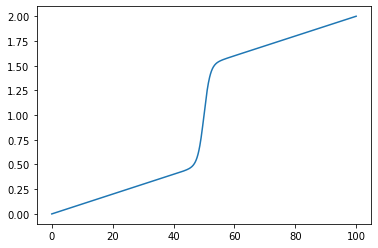

In [131]:
plt.plot(x, y_true)

In [145]:
from tensorflow.python.keras import backend as K

class BiasLayer(tf.keras.layers.Layer):
    def __init__(self, *args, **kwargs):
        super(BiasLayer, self).__init__(*args, **kwargs)
        
    def build(self, input_shape):
        self.bias = self.add_weight('bias',
                                    shape=input_shape[1:],
                                    initializer='zeros',
                                    trainable=True)
    def call(self, x):
        return x + self.bias
    

class BiasedPrelu(tf.keras.layers.Layer):
    def __init__(self, *args, **kwargs):
        super(BiasedPrelu, self).__init__(*args, **kwargs)

    def build(self, input_shape):
        self.bias = self.add_weight('bias',
                                    shape=input_shape[1:],
                                    initializer='zeros',
                                    trainable=True)
        self.alpha = self.add_weight('alpha',
                                    shape=input_shape[1:],
                                    initializer='zeros',
                                    trainable=True)
    def call(self, x):
        pos = K.relu(x + self.bias)
        neg = -self.alpha * K.relu(-x + self.bias)
        return pos + neg
    


inputs = tf.keras.Input(shape=(1,))
first_layer = BiasLayer()(inputs)
first_layer_prelu = tf.keras.layers.PReLU(trainable=True)(first_layer)

second_layer = BiasLayer()(first_layer_prelu)
second_layer_prelu = tf.keras.layers.PReLU(trainable=True)(second_layer)

third_layer = BiasLayer()(second_layer_prelu)
third_layer_prelu = tf.keras.layers.PReLU(trainable=True)(third_layer)

fourth_layer = BiasLayer()(third_layer_prelu)
fourth_layer_prelu = tf.keras.layers.PReLU(trainable=True)(fourth_layer)

fifth_layer = BiasLayer()(fourth_layer_prelu)
fifth_layer_prelu = tf.keras.layers.PReLU(trainable=True)(fifth_layer)

sixth_layer = BiasLayer()(fifth_layer_prelu)
sixth_layer_prelu = tf.keras.layers.PReLU(trainable=True)(sixth_layer)

seventh_layer = BiasLayer()(sixth_layer_prelu)
seventh_layer_prelu = tf.keras.layers.PReLU(trainable=True)(seventh_layer)

# model = tf.keras.Model(inputs=inputs, outputs=seventh_layer_prelu, name="combined")
architecture = np.array([[tf.keras.layers.Dense(1, activation='linear'), tf.keras.layers.PReLU(trainable=True)] for _ in range(10)]).flatten().tolist()
model = tf.keras.Sequential(architecture)
model.compile(loss=tf.keras.losses.mean_squared_error, optimizer='adam')
# model.build(input_shape=[1])

In [146]:
model.fit(x, y_true)
model.summary()

32/32 [==============================] - 0s 891us/step - loss: 1.5734
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 1)                 2         
_________________________________________________________________
p_re_lu_89 (PReLU)           (None, 1)                 1         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 2         
_________________________________________________________________
p_re_lu_90 (PReLU)           (None, 1)                 1         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 2         
_________________________________________________________________
p_re_lu_91 (PReLU)           (None, 1)                 1         
__________________________________________________

In [118]:
# model.weights

In [119]:
# model(np.array([1, 2, 3]))

In [120]:
# model.summary()

In [121]:
# first_layer

In [122]:
# model.trainable_variables

In [149]:
model.fit(x, y_true, epochs = 10000, verbose=False, batch_size=32, shuffle=True)
model.fit(x, y_true, epochs = 1)

32/32 [==============================] - 0s 797us/step - loss: 1.5734


(0.0, 100.0)

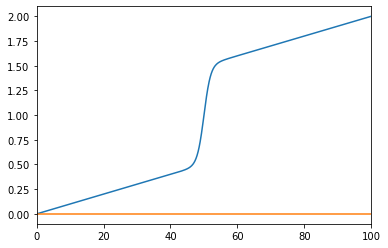

In [148]:
y_pred = model(x)
plt.plot(x,y_true)
plt.plot(x, y_pred)
plt.xlim([0, 100])

In [101]:
model.trainable_variables

[<tf.Variable 'bias_layer_7/bias:0' shape=(1,) dtype=float32, numpy=array([-7.501589], dtype=float32)>,
 <tf.Variable 'p_re_lu_7/alpha:0' shape=(1,) dtype=float32, numpy=array([0.74656004], dtype=float32)>,
 <tf.Variable 'bias_layer_8/bias:0' shape=(1,) dtype=float32, numpy=array([-7.501589], dtype=float32)>,
 <tf.Variable 'p_re_lu_8/alpha:0' shape=(1,) dtype=float32, numpy=array([0.9747951], dtype=float32)>,
 <tf.Variable 'bias_layer_9/bias:0' shape=(1,) dtype=float32, numpy=array([-7.501589], dtype=float32)>,
 <tf.Variable 'p_re_lu_9/alpha:0' shape=(1,) dtype=float32, numpy=array([1.1162758], dtype=float32)>,
 <tf.Variable 'bias_layer_10/bias:0' shape=(1,) dtype=float32, numpy=array([-7.501589], dtype=float32)>,
 <tf.Variable 'p_re_lu_10/alpha:0' shape=(1,) dtype=float32, numpy=array([1.003921], dtype=float32)>,
 <tf.Variable 'bias_layer_11/bias:0' shape=(1,) dtype=float32, numpy=array([-7.501588], dtype=float32)>,
 <tf.Variable 'p_re_lu_11/alpha:0' shape=(1,) dtype=float32, numpy=ar

In [102]:
first_layer(x)

TypeError: 'Tensor' object is not callable

In [ ]:
model.weights